In [1]:
import os
import sys 

import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import tensorflow as tf
# from keras import backend as K
from skimage import io
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

from data_generator_3d import *
from cnn_baseline import *
from plotting_helpers import plot_auc

print(tf.__version__)

# from keras.utils import multi_gpu_model

1.14.0


In [2]:
image_generator = ImageDataGenerator(
#     rotation_range=5,
    rescale=1./255,
#     shear_range=.1, 
#     zoom_range=.05,
#     brightness_range=[.85, 1.0],
#     zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=5,
    width_shift_range=5,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator = ImageDataGenerator(
    validation_split=0.0
)

# train_generator = image_generator.flow_from_directory(
#     directory="data/nlst_train/image_full",
#     color_mode="grayscale",
#     target_size=(256, 256),
#     batch_size=12,
#     class_mode="binary",
#     shuffle=True,
#     seed=42
# )

# train_generator = image_generator.flow_from_directory(
#     directory="data/nlst_train/image_roi_2d",
#     color_mode="grayscale",
#     target_size=(32, 32),
#     batch_size=16,
#     class_mode="binary",
#     shuffle=True,
#     seed=42
# )

train_generator = generator(
    base_directory='data/nlst_train/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
    
)

val_generator = generator(
    base_directory='data/nlst_val/image_roi_3d',
    input_gen=image_generator,
    target_gen=label_generator,
    batch_sz=1
    
)

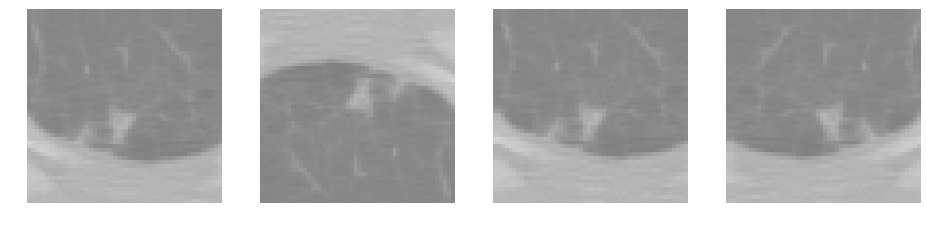

In [3]:
show_augmentation('data/nlst_train/image_roi_3d/25/0.tif', image_generator, n_rows=1)

In [4]:
def convert_to_logits(y_pred):
    y_pred = tf.clip_by_value(
        y_pred, tf.keras.backend.epsilon(),
        1 - tf.keras.backend.epsilon()
    )

    return tf.math.log(y_pred / (1 - y_pred))


def weighted_cross_entropy(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        logits=y_pred,
        labels=y_true,
        pos_weight=1050
    )
    return tf.reduce_mean(loss)

In [5]:
# model = cnn_baseline()
# model = cnn_baseline(input_shape=(32, 32, 1))
model = cnn_baseline_3d(input_shape=(50, 50, 50, 1))

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = 5e-5),
#     loss=tf.keras.losses.binary_crossentropy,
    loss=weighted_cross_entropy,
    metrics = [
        'accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.SpecificityAtSensitivity(.5),
    ]
)
# model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=0, save_best_only=True)
# parallel_model = multi_gpu_model(model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 50, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 48, 48, 48, 32)    896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 48, 48, 48, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 46, 46, 46, 64)    55360     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 46, 46, 46, 64)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 15, 15, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 13, 13, 128)   221312

In [7]:
model_history = model.fit_generator(
    train_generator,
    validation_data= val_generator,
    validation_steps=200,
    steps_per_epoch=1000,
    epochs = 12
)

Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Epoch 1/12
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found 658 images belonging to 1 classes.
Found

Epoch 12/12
1000/1000 [==============================] - 59s 59ms/step - loss: 1.3354 - acc: 0.6500 - precision: 0.2955 - recall: 0.2301 - auc: 0.5228 - specificity_at_sensitivity: 0.3811 - val_loss: 1.5909 - val_acc: 0.5650 - val_precision: 0.1875 - val_recall: 0.0984 - val_auc: 0.4065 - val_specificity_at_sensitivity: 0.4245


In [8]:
model.save('nlst_cnn.hdf5') 

In [9]:
# model.load_weights('nlst_cnn_curbest.hdf5')
model.load_weights('nlst_cnn.hdf5')

In [10]:
with open('data/nlst_test/image_roi_3d/patient_lookup.pkl', 'rb') as input_file:
    PatientLookup = pkl.load(input_file)

Patient_Xs = {}
Patient_Ys = {}

Xs = []
Ys = []
for im in os.listdir('data/nlst_test/image_roi_3d/pkls/'):
    path = f'data/nlst_test/image_roi_3d/pkls/{im}'
    with open(path, 'rb') as input_file:
        cube, label = pkl.load(input_file)
    cube = cube[:50][:50][:50]
    if cube.shape[0] < 50 or cube.shape[1] < 50 or cube.shape[2] < 50:
        pass
    else:
        pid = PatientLookup[int(im[:-4])]
        if Patient_Xs.get(pid):
            Patient_Xs[pid].append(np.array(cube/255).reshape(50, 50, 50, 1))
        else:
            Patient_Xs[pid] = [np.array(cube/255).reshape(50, 50, 50, 1)]
        Patient_Ys[pid] = label
        Xs.append(np.array(cube/255).reshape(50, 50, 50, 1))
        Ys.append(label)

0.7482014388489209
0.5708771929824562


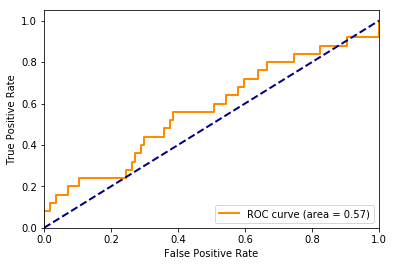

In [11]:
Xs = np.array(Xs)
Ys = np.array(Ys)
x = np.concatenate([model.predict(Xs[i*10:(i+1)*10]) for i in range(14)])
print(accuracy_score(Ys, np.round(x)))
print(roc_auc_score(Ys, x))

fig, ax = plt.subplots(1, 1)
plot_auc(Ys, x, ax)

Patient accuracy (using mean score):    0.7076923076923077
Patient accuracy (using highest value): 0.7076923076923077

Patient AUC (using mean score):    0.5957446808510638
Patient AUC (using highest value): 0.6418439716312057


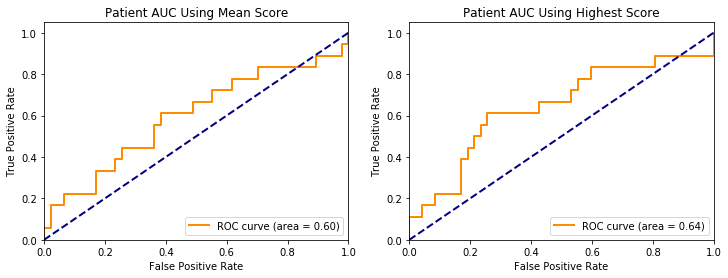

In [12]:
patient_preds_mean = []
patient_preds_greatest = []

for pid, Xs in Patient_Xs.items():
    preds = model.predict(np.array(Xs))
    patient_preds_mean.append(preds.mean())
    preds = sorted(preds, key=lambda x: abs(x-.5), reverse=True)
    patient_preds_greatest.append(np.array(preds[:1]).mean())
    
print("Patient accuracy (using mean score):    " + str(accuracy_score(list(Patient_Ys.values()), np.round(patient_preds_mean))))
print("Patient accuracy (using highest value): " + str(accuracy_score(list(Patient_Ys.values()), np.round(patient_preds_greatest))))

print("\nPatient AUC (using mean score):    " + str(roc_auc_score(list(Patient_Ys.values()), patient_preds_mean)))
print("Patient AUC (using highest value): " + str(roc_auc_score(list(Patient_Ys.values()), patient_preds_greatest)))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_auc(list(Patient_Ys.values()), patient_preds_mean, axs[0])
plot_auc(list(Patient_Ys.values()), patient_preds_greatest, axs[1])

axs[0].set_title("Patient AUC Using Mean Score")
axs[1].set_title("Patient AUC Using Highest Score")

plt.show()

In [13]:
Patient_Ys.values()

dict_values([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [14]:
np.round(patient_preds_mean)

array([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [15]:
patient_preds_mean

[0.45886764,
 0.49237928,
 0.47675332,
 0.4535722,
 0.508988,
 0.48629957,
 0.50959986,
 0.4782084,
 0.47914407,
 0.4562577,
 0.4553543,
 0.4567511,
 0.4577695,
 0.45573252,
 0.47311243,
 0.4865577,
 0.46157062,
 0.4608271,
 0.4564479,
 0.4949377,
 0.48661825,
 0.46763995,
 0.50635594,
 0.45615244,
 0.4802789,
 0.45993292,
 0.47497106,
 0.5030272,
 0.49271625,
 0.5140514,
 0.46885115,
 0.45567572,
 0.46243802,
 0.45377705,
 0.4575139,
 0.45684916,
 0.45439112,
 0.45267558,
 0.4777585,
 0.47615132,
 0.4801269,
 0.44994658,
 0.4592149,
 0.45313412,
 0.4641751,
 0.5169327,
 0.4570039,
 0.48685122,
 0.45518106,
 0.47694644,
 0.47419906,
 0.46396214,
 0.45598742,
 0.45339534,
 0.4556107,
 0.50385803,
 0.5049497,
 0.4631543,
 0.45329654,
 0.46279106,
 0.45540202,
 0.47361776,
 0.4970167,
 0.47223514,
 0.50858927]